In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/mujoco_wrappers.py
    
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

# Implementing Proximal Policy Optimization 


In this notebook you will be implementing Proximal Policy Optimization algorithm, 
scaled up version of which was used to train [OpenAI Five](https://openai.com/blog/openai-five/) 
to [win](https://openai.com/blog/how-to-train-your-openai-five/) against the
world champions in Dota 2.
You will be solving a continuous control environment on which it may be easier and faster 
to train an agent, however note that PPO here may not be the best algorithm as, for example,
Deep Deterministic Policy Gradient and Soft Actor Critic may be more suited 
for continuous control environments. To run the environment you will need to install 
[pybullet-gym](https://github.com/benelot/pybullet-gym) which unlike MuJoCo 
does not require you to have a license.

To install the library:

In [2]:
!git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
!pip install -e lib/pybullet-gym

fatal: destination path 'lib/pybullet-gym' already exists and is not an empty directory.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Obtaining file:///home/mars/projects/YSDA/4/RL/Practical_RL/week09_policy_II/lib/pybullet-gym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pybulletgym
    Found existing installation: pybulletgym 0.1
    Uninstalling pybulletgym-0.1:
      Successfully uninstalled pybulletgym-0.1
  Running setup.py develop for pybulletgym
You should consider upgrading via the '/home/mars/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
from tqdm import tqdm
from sklearn.metrics import r2_score

The overall structure of the code is similar to the one in the A2C optional homework, but don't worry if you haven't done it, it should be relatively easy to figure it out. 
First, we will create an instance of the environment. 
We will normalize the observations and rewards, but before that you will need a wrapper that will 
write summaries, mainly, the total reward during an episode. You can either use one for `TensorFlow` 
implemented in `atari_wrappers.py` file from the optional A2C homework, or implement your own. 

In [3]:
import gym 
import pybulletgym

env = gym.make("HalfCheetahMuJoCoEnv-v0")
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset())
print("action space: ", env.action_space, 
      "\naction_sample: ", env.action_space.sample())

WalkerBase::__init__
observation space:  Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf], (17,), float32) 
observations: [-0.06886479 -0.0392984  -0.07134221 -0.03681757  0.07730743  0.01537143
 -0.01464386  0.08045819  0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
action space:  Box([-1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1.], (6,), float32) 
action_sample:  [ 0.53032863  0.07496662 -0.55764437 -0.9919691  -0.12419752 -0.3679923 ]


/home/mars/anaconda3/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
import numpy as np

class Summaries(gym.Wrapper):
    """ Wrapper to write summaries. """
    def __init__(self, env):
        super().__init__(env)
        self.episode_counter = 0
        self.current_step_var = 0

        self.episode_rewards = []
        self.episode_lens = []

        self.current_reward = 0
        self.current_len = 0

    def step(self, action):
        obs, rew, done, info = self.env.step(action)

        self.current_reward += rew
        self.current_len += 1
        self.current_step_var += 1

        if done:
            self.episode_rewards.append((self.current_step_var, self.current_reward))
            self.episode_lens.append((self.current_step_var, self.current_len))

        return obs, rew, done, info

    def reset(self, **kwargs):
        self.episode_counter += 1

        self.current_reward = 0
        self.current_len = 0

        return self.env.reset(**kwargs)

The normalization wrapper will subtract running mean from observations and rewards and divide 
the resulting quantities by the  running variances.

In [5]:
from mujoco_wrappers import Normalize

env = Normalize(Summaries(gym.make("HalfCheetahMuJoCoEnv-v0")));
env.unwrapped.seed(0);

WalkerBase::__init__


Next, you will need to define a model for training. We suggest that you use two separate networks: one for policy
and another for value function. Each network should be a 3-layer MLP with 64 hidden units, $\mathrm{tanh}$ 
activation function.

Our policy distribution is going to be multivariate normal with diagonal covariance. 
The network from above will predict the mean, and the covariance should be represented by a single 
(learned) vector of size 6 (corresponding to the dimensionality of the action space from above). Or you can also predict the variance using your model. You should take the exponent of that values to always have a non-negative quantity. 

Overall the model should return three things: predicted mean of the distribution, variance vector, 
value function. 

In [6]:
state_dim = env.observation_space.shape
device = 'cpu'

In [7]:
# import tensorflow as tf
import torch

from torch import nn
from torch.nn import functional as F
import torch


class PolicyModel(nn. Module):
    def __init__(self):
        super(PolicyModel, self).__init__()
        self.h = 64
    
        self.policy_model = nn.Sequential(nn.Linear(state_dim[0], self.h), nn.Tanh(),
                                        nn.Linear(self.h, 6 + 6)).to(device)

        self.value_model = nn.Sequential(nn.Linear(state_dim[0], self.h), nn.Tanh(),
                                        nn.Linear(self.h, 1)).to(device)
        
    def get_policy(self, x):
        out = self.policy_model(x.float().to(device))
        means = out[:,:6]
        var = out[:,6:]
        return means, var

    def get_value(self, x):
        out = self.value_model(x.float().to(device))
        return out

    def forward(self, x):
        policy = self.get_policy(x)
        value = self.get_value(x)

        return policy, value

This model will be wrapped by a `Policy`. The policy can work in two modes, but in either case 
it is going to return dictionary with string-type keys. The first mode is when the policy is 
used to sample actions for a trajectory which will later be used for training. In this case 
the flag `training` passed to `act` method is `False` and the method should return 
a `dict` with the following keys: 

* `"actions"`: actions to pass to the environment
* `"log_probs"`: log-probabilities of sampled actions
* `"values"`: value function $V^\pi(s)$ predictions.

We don't need to use the values under these keys for training, so all of them should be of type `np.ndarray`.

When `training` is `True`, the model is training on a given batch of observations. In this
case it should return a `dict` with the following keys

* `"distribution"`: an instance of multivariate normal distribution (`torch.distributions.MultivariateNormal` or `tf.distributions.MultivariateNormalDiag`)
* `"values"`: value function $V^\pi(s)$ prediction.

The distinction about the modes comes into play depending on where the policy is used: if it is called from `EnvRunner`, 
the `training` flag is `False`, if it is called from `PPO`, the `training` flag is `True`. These classed 
will be described below. 

In [8]:
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

class Policy:
    def __init__(self, model):
        self.model = model
        self.model.to(device)
    
    def act(self, inputs, training=False):
        inputs = torch.tensor(inputs)
        if inputs.ndim < 2:
            inputs = inputs.unsqueeze(0)
        inputs = inputs.to(device)
        
        batch_size = inputs.shape[0]

        #< insert your code here >
        means, var = self.model.get_policy(inputs)
        #var = nn.Tanh()(var)
        var = torch.clamp(var, -10, 1)
        covar_matrix = torch.exp(var)
        normal_distr = Normal(means, covar_matrix)

        actions = normal_distr.sample()
        log_probs = normal_distr.log_prob(actions)

        values = self.model.get_value(inputs)

        if not training:
            return {'actions': actions.cpu().numpy().tolist()[0], 
                    'log_probs': log_probs[0].detach().cpu().numpy(),
                    'values': values[0].detach().cpu().numpy()}
        else:
            return {'distribution': normal_distr, 'values': values}

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. Calling `.get_next()` on a runner will return a trajectory &mdash; dictionary 
containing keys

* `"observations"`
* `"rewards"` 
* `"resets"`
* `"actions"`
* all other keys that you defined in `Policy`,

under each of these keys there is a `np.ndarray` of specified length $T$ &mdash; the size of partial trajectory. 

Additionally, before returning a trajectory this runner can apply a list of transformations. 
Each transformation is simply a callable that should modify passed trajectory in-place.

In [9]:
class AsArray:
    """ 
    Converts lists of interactions to ndarray.
    """
    def __call__(self, trajectory):
        # Modify trajectory inplace. 
        for k, v in filter(lambda kv: kv[0] != "state", trajectory.items()):
            trajectory[k] = np.asarray(v)

In [10]:
""" RL env runner """
from collections import defaultdict

import numpy as np


class EnvRunner:
    """ Reinforcement learning runner in an environment with given policy """

    def __init__(self, env, policy, nsteps, transforms=None, step_var=None):
        self.env = env
        self.policy = policy
        self.nsteps = nsteps
        self.transforms = transforms or []
        self.step_var = step_var if step_var is not None else 0
        self.state = {"latest_observation": self.env.reset()}

    @property
    def nenvs(self):
        """ Returns number of batched envs or `None` if env is not batched """
        return getattr(self.env.unwrapped, "nenvs", None)

    def reset(self):
        """ Resets env and runner states. """
        self.state["latest_observation"] = self.env.reset()
        self.policy.reset()

    def get_next(self):
        """ Runs the agent in the environment.  """
        trajectory = defaultdict(list, {"actions": []})
        observations = []
        rewards = []
        resets = []
        self.state["env_steps"] = self.nsteps

        for i in range(self.nsteps):
            observations.append(self.state["latest_observation"])
            act = self.policy.act(self.state["latest_observation"])
            if "actions" not in act:
                raise ValueError("result of policy.act must contain 'actions' "
                                 f"but has keys {list(act.keys())}")
            for key, val in act.items():
                trajectory[key].append(val)

            obs, rew, done, _ = self.env.step(trajectory["actions"][-1])
            self.state["latest_observation"] = obs
            rewards.append(rew)
            resets.append(done)
            self.step_var += self.nenvs or 1

            # Only reset if the env is not batched. Batched envs should
            # auto-reset.
            if not self.nenvs and np.all(done):
                self.state["env_steps"] = i + 1
                self.state["latest_observation"] = self.env.reset()

        trajectory.update(
            observations=observations,
            rewards=rewards,
            resets=resets)
        trajectory["state"] = self.state

        for transform in self.transforms:
            transform(trajectory)
        return trajectory

In [11]:
import numpy as np

class DummyPolicy:
    def act(self, inputs, training=False):
        assert not training
        return {"actions": np.random.randn(6), "values": np.nan}

runner = EnvRunner(env, DummyPolicy(), 3,
                   transforms=[AsArray()])
trajectory = runner.get_next()

{k: v.shape for k, v in trajectory.items() if k != "state"}

{'actions': (3, 6),
 'values': (3,),
 'observations': (3, 17),
 'rewards': (3,),
 'resets': (3,)}

You will need to implement the following two transformations. 

The first is `GAE` that implements [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438).
In it you should add two keys to the trajectory: `"advantages"` and `"value_targets"`. In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential 
moving average with parameter $\lambda$ of the regular advantages 
$\hat{A}^{(T)}(s_t) = \sum_{l=0}^{T-1-t} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{T}) - V^\pi(s_t)$. 
The exact formula for the computation is the following

$$
A_{t}^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-1-t} (\gamma\lambda)^l\delta_{t + l}^V, \, t \in [0, T)
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$. You can look at the 
derivation (formulas 11-16) in the paper. Don't forget to reset the summation on terminal
states as determined by the flags `trajectory["resets"]`. You can use `trajectory["values"]`
to get values of all observations except the most recent which is stored under 
 `trajectory["state"]["latest_observation"]`. For this observation you will need to call the policy 
 to get the value prediction.

Once you computed the advantages, you can get the targets for training the value function by adding 
back values:
$$
\hat{V}(s_{t+l}) = A_{t+l}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t + l}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function. 

In [12]:
import os
from collections import deque

class GAE:
    """ Generalized Advantage Estimator. """
    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_

    def __call__(self, trajectory):
        gamma = self.gamma
        lambda_ = self.lambda_
        
        advantages = deque()
        value_targets = deque()

        rewards = trajectory["rewards"]
        values = list(trajectory["values"])
        resets = 1 - trajectory["resets"] 
        acted_policy = self.policy.act(trajectory["state"]["latest_observation"], training = False)
        values.append(acted_policy["values"])

        prev_gae = 0
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step + 1] * resets[step] - values[step] 
            advantage = delta + self.gamma * self.lambda_ * prev_gae * resets[step]
            prev_gae =  delta + self.gamma * self.lambda_ * prev_gae * resets[step]
            advantages.appendleft(advantage)
            value_targets.appendleft(advantage + values[step])

        trajectory['advantages'] = np.array(advantages)[...,0]
        trajectory["value_targets"] = np.array(value_targets)

In [13]:
def test_gae():
    '''
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/actions.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/log_probs.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/values.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/observations.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/rewards.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/resets.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/state.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/advantages.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/value_targets.npy
    !curl -O https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/test_ppo/policy
    '''
    trajectory = {}
    for key in ['actions', 'log_probs', 'values', 'observations', 'rewards', 'resets']:
        trajectory[key] = np.load(f'{key}.npy', allow_pickle=True)
    trajectory['state'] = {"latest_observation": np.load('state.npy')}
    
    policy = torch.load(f'policy')
    gae_to_test = GAE(policy, gamma=0.99, lambda_=0.95)
    
    gae_to_test(trajectory)
    
    for key in ['advantages', 'value_targets']:
        assert np.allclose(np.load(f'{key}.npy'), trajectory[key], atol=2e-2)
    
    print("It's all good!")
test_gae()

It's all good!


The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps 
an `EnvRunner`. It should call the runner to get a trajectory, then return minibatches 
from it for a number of epochs, shuffling the data before each epoch.

In [14]:
class TrajectorySampler:
    """ Samples minibatches from trajectory for a number of epochs. """
    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.trajectory = None

    def shuffle_trajectory(self):
        """ Shuffles all elements in trajectory.

        Should be called at the beginning of each epoch.
        """
        trajectory_len = self.trajectory["observations"].shape[0]

        permutation = np.random.permutation(trajectory_len)
        for key, value in self.trajectory.items():
            if key != 'state':
                self.trajectory[key] = value[permutation]

    def get_next(self):
        """ Returns next minibatch.  """
        if not self.trajectory:
            self.trajectory = self.runner.get_next()

        if self.minibatch_count == self.num_minibatches:
            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count += 1

        if self.epoch_count == self.num_epochs:
            self.trajectory = self.runner.get_next()

            self.shuffle_trajectory()
            self.minibatch_count = 0
            self.epoch_count = 0

        trajectory_len = self.trajectory["observations"].shape[0]

        batch_size = trajectory_len//self.num_minibatches

        minibatch = {}
        for key, value in self.trajectory.items():
            if key != 'state':
                minibatch[key] = value[self.minibatch_count*batch_size: (self.minibatch_count + 1)*batch_size]

        self.minibatch_count += 1

        for transform in self.transforms:
            transform(minibatch)

        return minibatch

A common trick to use with GAE is to normalize advantages, please implement the normalization.

In [15]:
class NormalizeAdvantages:
    """ Normalizes advantages to have zero mean and variance 1. """
    def __call__(self, trajectory):
        adv = trajectory["advantages"]
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        trajectory["advantages"] = adv

Finally, we can create our PPO runner. 

In [16]:
def make_ppo_runner(env, policy, num_runner_steps=2048,
                    gamma=0.99, lambda_=0.95, 
                    num_epochs=10, num_minibatches=32):
    """ Creates runner for PPO algorithm. """
    runner_transforms = [AsArray(),
                       GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, 
                     transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(runner, num_epochs=num_epochs, 
                              num_minibatches=num_minibatches,
                              transforms=sampler_transforms)
    return sampler

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
J_{\pi}(s, a) = \frac{\pi_\theta(a|s)}{\pi_\theta^{\text{old}}(a|s)} \cdot A^{\mathrm{GAE}(\gamma,\lambda)}(s, a)
$$

$$
J_{\pi}^{\text{clipped}}(s, a) = \mathrm{clip}\left(
\frac{\pi_\theta(a|s)}{\pi_{\theta^{\text{old}}}(a|s)},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\cdot A^{\mathrm{GAE(\gamma, \lambda)}}(s)\\
$$

$$
L_{\text{policy}} = -\frac{1}{T}\sum_{l=0}^{T-1}\min\left(J_\pi(s_{t + l}, a_{t + l}), J_{\pi}^{\text{clipped}}(s_{t + l}, a_{t + l})\right).
$$

The value loss is also modified:

$$
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1} \max(l^{simple}(s_{t + l}), l^{clipped}(s_{t + l}))
$$
, where $l^{simple}$ is your standard critic loss
$$
l^{simple}(s_{t + l}) = [V_\theta(s_{t+l}) - G(s_{t + l})]^2
$$

and $l^{clipped}$ is a clipped version that limits large changes of the value function:
$$
l^{clipped}(s_{t + l}) = [
V_{\theta^{\text{old}}}(s_{t+l}) +
\text{clip}\left(
V_\theta(s_{t+l}) - V_{\theta^\text{old}}(s_{t+l}),
-\text{cliprange}, \text{cliprange}
\right) - G(s_{t + l})] ^ 2
$$

In [17]:
class PPO:
    def __init__(self, policy, optimizer,
               cliprange=0.2,
               value_loss_coef=0.25,
               max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm

    def policy_loss(self, trajectory, act):
        """ Computes and returns policy loss on a given trajectory. """
        actions = torch.tensor(trajectory["actions"]).to(device) 
        old_logprobs = torch.tensor(trajectory["log_probs"]).sum(1).to(device)#.flatten() 
        new_logprobs = act["distribution"].log_prob(actions).sum(1)
        
        ratio = torch.exp(new_logprobs - old_logprobs)
        self._policy_loss = torch.mean(torch.max(- ratio * torch.Tensor(trajectory["advantages"]).to(device), 
                                                - torch.clamp(ratio, 1 - self.cliprange, 1 + self.cliprange) * torch.Tensor(trajectory["advantages"]).to(device) ))
        
        return self._policy_loss

    def value_loss(self, trajectory, act):
        """ Computes and returns value loss on a given trajectory. """
        new_values = act["values"].flatten() 
        returns = torch.tensor(trajectory["value_targets"]).to(device)
        values = torch.tensor(trajectory["values"]).to(device).flatten()

        v_loss_1  = (returns - new_values).pow(2)
        clipped_values = values + torch.clamp(new_values - values,
                                              -self.cliprange,
                                              self.cliprange)
        v_loss_2 = (clipped_values - returns ).pow(2)
        
        self._value_loss = 0.5 * (torch.max(v_loss_1,v_loss_2)).mean()
        return self._value_loss

    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)
        policy_loss = self.policy_loss(trajectory, act)
        value_loss = self.value_loss(trajectory, act)

        return policy_loss + self.value_loss_coef * value_loss

    def step(self, trajectory):
        """ Computes the loss function and performs a single gradient step. """
        self.optimizer.zero_grad()
        loss = self.loss(trajectory)

        loss.backward()

        grad_norm = nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)

        self.optimizer.step()

Now everything is ready to do training. In one million of interactions it should be possible to 
achieve the total raw reward of about 1500. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with the environment. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages

For optimization it is suggested to use Adam optimizer with linearly annealing learning rate 
from 3e-4 to 0 and epsilon 1e-5.

In [18]:
model = PolicyModel()
#model = model.cuda()

policy = Policy(model)

runner = make_ppo_runner(env, policy)

In [19]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

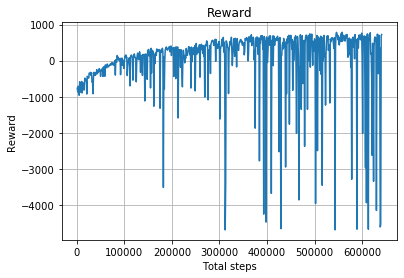

100%|██████████| 100000/100000 [17:04<00:00, 97.59it/s]


In [20]:
optimizer = torch.optim.Adam(policy.model.parameters(), lr = 3e-4, eps=1e-5)
epochs = 100000

lr_mult = lambda epoch: (1 - (epoch/epochs))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = PPO(policy, optimizer)

for epoch in tqdm(range(epochs)):
    trajectory = runner.get_next()

    if (epoch + 1) % 100 == 0:
        clear_output(True)
        rewards = np.array(env.env.episode_rewards)

        if rewards.size > 0:
            plt.plot(rewards[:, 0], rewards[:, 1], label = "episode rewards")
            plt.title("Reward")
            plt.xlabel("Total steps")
            plt.ylabel("Reward")
            plt.grid()
            plt.show()

    ppo.step(trajectory)
    sched.step()

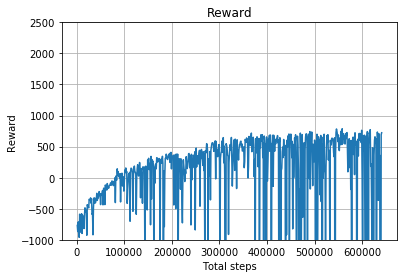

In [21]:
rewards = np.array(env.env.episode_rewards)

if rewards.size > 0:
    plt.plot(rewards[:, 0], rewards[:, 1], label = "episode rewards")
    plt.title("Reward")
    plt.xlabel("Total steps")
    plt.ylabel("Reward")
    plt.ylim(-1000, 2500)
    plt.grid()
    plt.show()